# Intro to Anomaly Detection with PyOD and ADbench

*Written by Joshua Harvey, for Prospect 33, 2024.*

Anomaly detection involves identifying observations that deviate significantly from the norm. It is a key component of data quality processes (DQ), along with missing value imputation and data drift.

PyOD is a comprehensive library for detecting outliers in multivariate data. It provides various algorithms and utilities for anomaly detection.

ADbench is a set of benchmark datasets pooled from a large number of published papers and previously used open-source datasets. For this notebook, we are only using the ADbench datasets, so these can be downloaded separately if you have issues with installing ADbench (eg dependency clashes).

Shap is a library for implementing the SHAP (Shapley Additive exPlanations) explainability framework. It provides both model-specific and model-agnostic approaches for ML explainability.


## 1. Setup and Installation
Let's start by installing the required libraries. It is strongly recommended to build inside a dedicated environment.

In [ ]:
%pip install pyod adbench matplotlib seaborn shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  

We also need to download the datasets for ADbench

In [ ]:
from adbench.myutils import Utils
utils = Utils() # utility function
# download datasets from the remote github repo
utils.download_datasets(repo='github')

## 2. Load and Explore an ADbench Dataset

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.knn import KNN  # Example anomaly detector
import shap  # For SHAP values explanation

In [ ]:
# Load a dataset from ADbench
adbench_dir = '/path/to/your/environment/eg/lib/python3.11/site-packages/adbench/datasets/Classical/' # change this to your adbench directory
dataset_name = '2_annthyroid.npz'  # You can change this to another dataset, see https://github.com/Minqi824/ADBench/tree/main/adbench/datasets/Classical
data = np.load(adbench_dir+dataset_name, allow_pickle=True)
X, y = data['X'], data['y']

In [ ]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dataset: {dataset_name}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Dataset: 2_annthyroid.npz
Training set shape: (5040, 6)
Test set shape: (2160, 6)


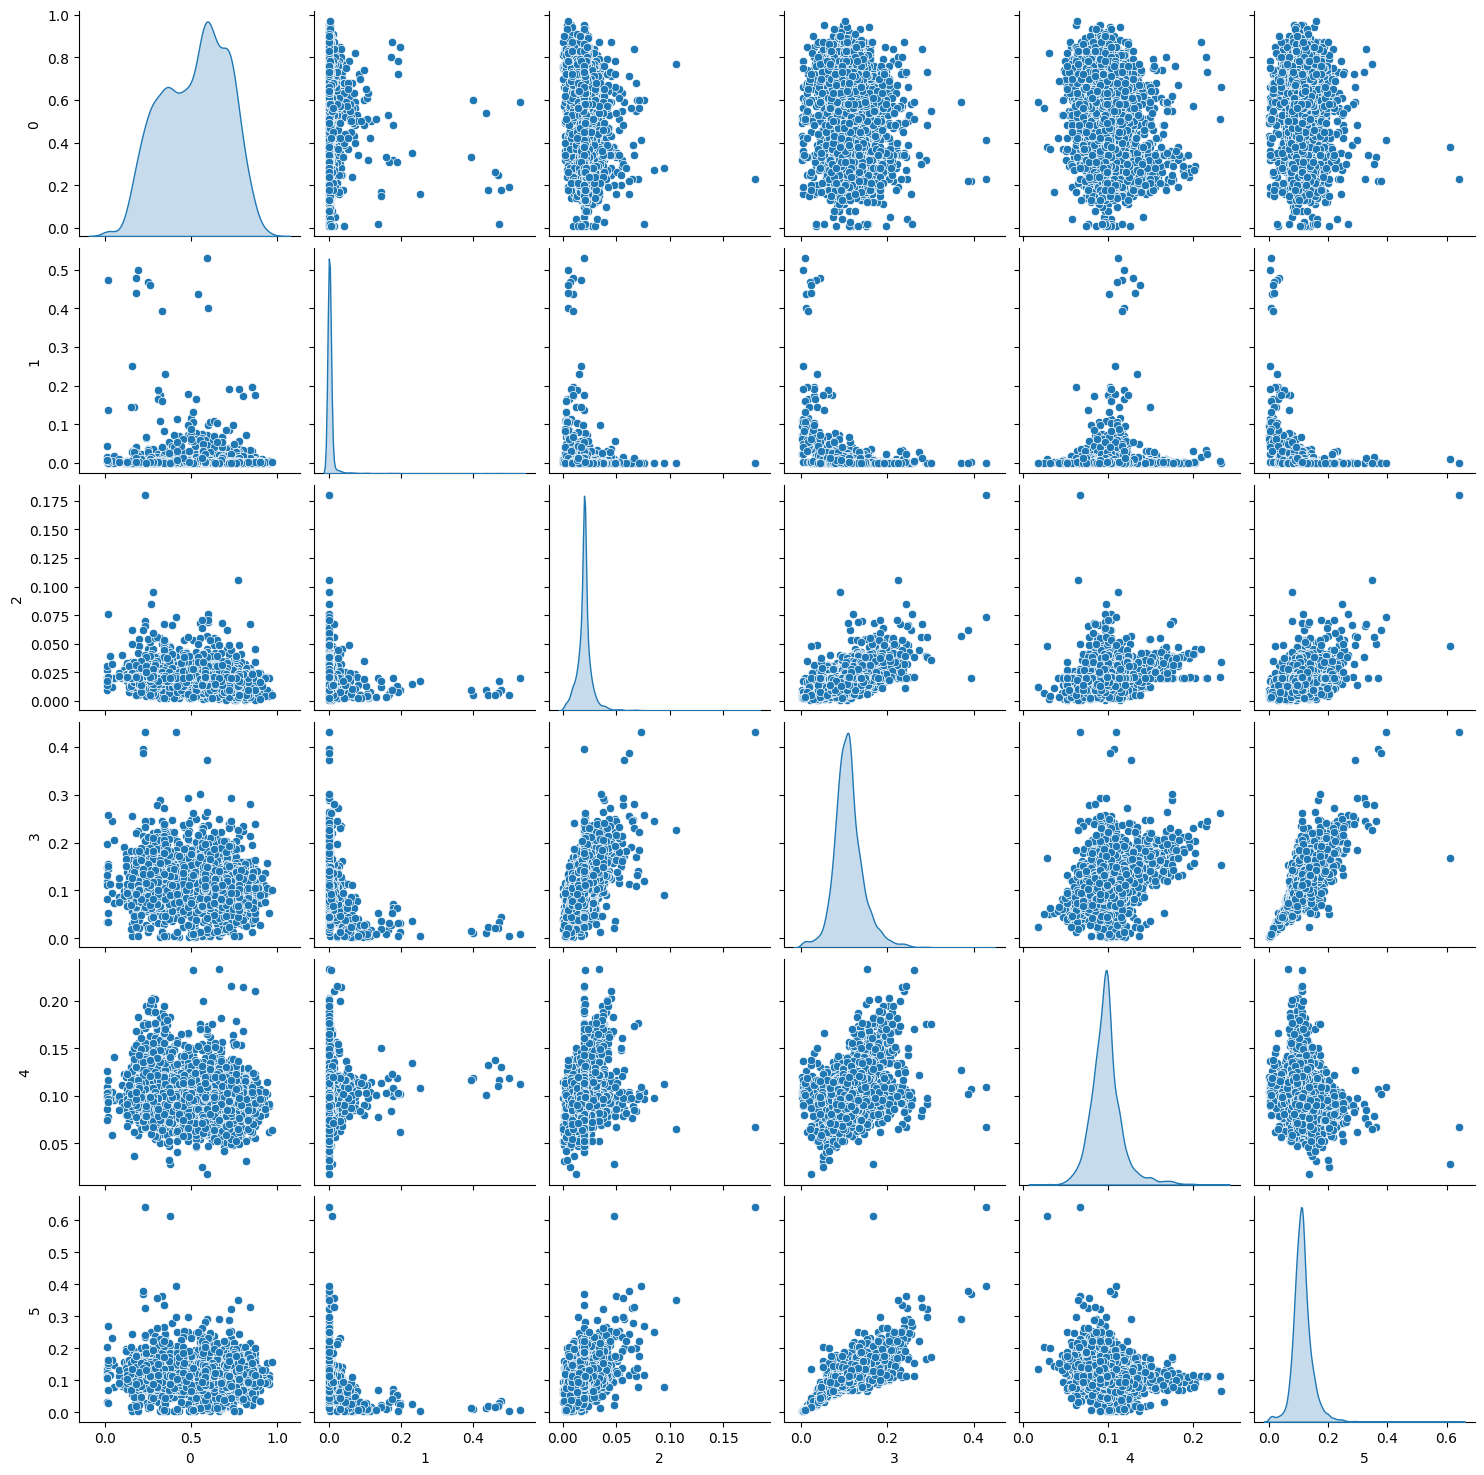

In [ ]:
# Visualize the data distribution (use a subset if too large)
sns.pairplot(pd.DataFrame(X_train), diag_kind='kde')
plt.show()

## 3. Using PyOD for Anomaly Detection


In [ ]:
# Initialize a PyOD model (KNN as an example)
clf = KNN()

# Train the model
clf.fit(X_train)

# Predict anomalies on the test set
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

## 4. Evaluating Anomaly Detection Model Performance

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Evaluate the model
auc = roc_auc_score(y_test, y_test_scores)
accuracy = accuracy_score(y_test, y_test_pred)

print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

ROC AUC: 0.7522
Accuracy: 0.8861


## 5. Visualizing Results

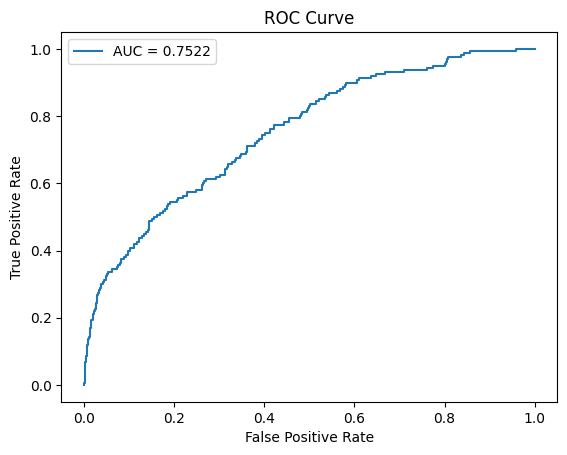

In [ ]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

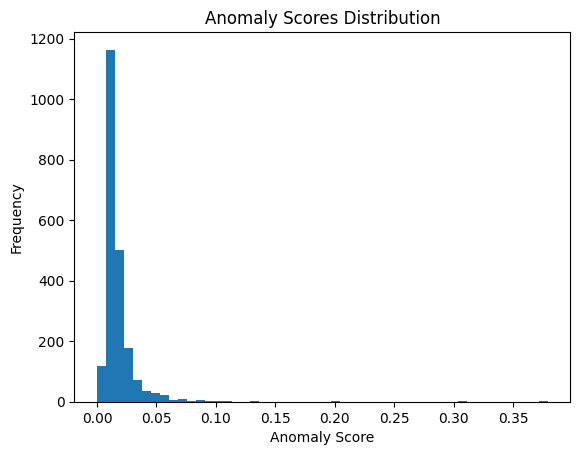

In [ ]:
# Visualize anomaly scores
plt.hist(y_test_scores, bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution')
plt.show()

In [ ]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives
df = pd.DataFrame(X_train)
df['y'] = y_train
df['y_pred'] = clf.predict(X_train)


In [ ]:
def label_outcome(row):
    if row['y'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative


In [ ]:
df['outcome'] = df.apply(label_outcome, axis=1)
df = df.drop(['y', 'y_pred'], axis=1)
df.head()

,0,1,2,3,4,5,outcome
0,0.28,0.00208,0.017,0.116,0.101,0.115,TN
1,0.74,0.00300,0.012,0.096,0.093,0.103,TN
2,0.85,0.00140,0.006,0.124,0.096,0.129,TN
3,0.34,0.00680,0.024,0.096,0.104,0.090,FN
4,0.46,0.00091,0.024,0.124,0.104,0.118,TN


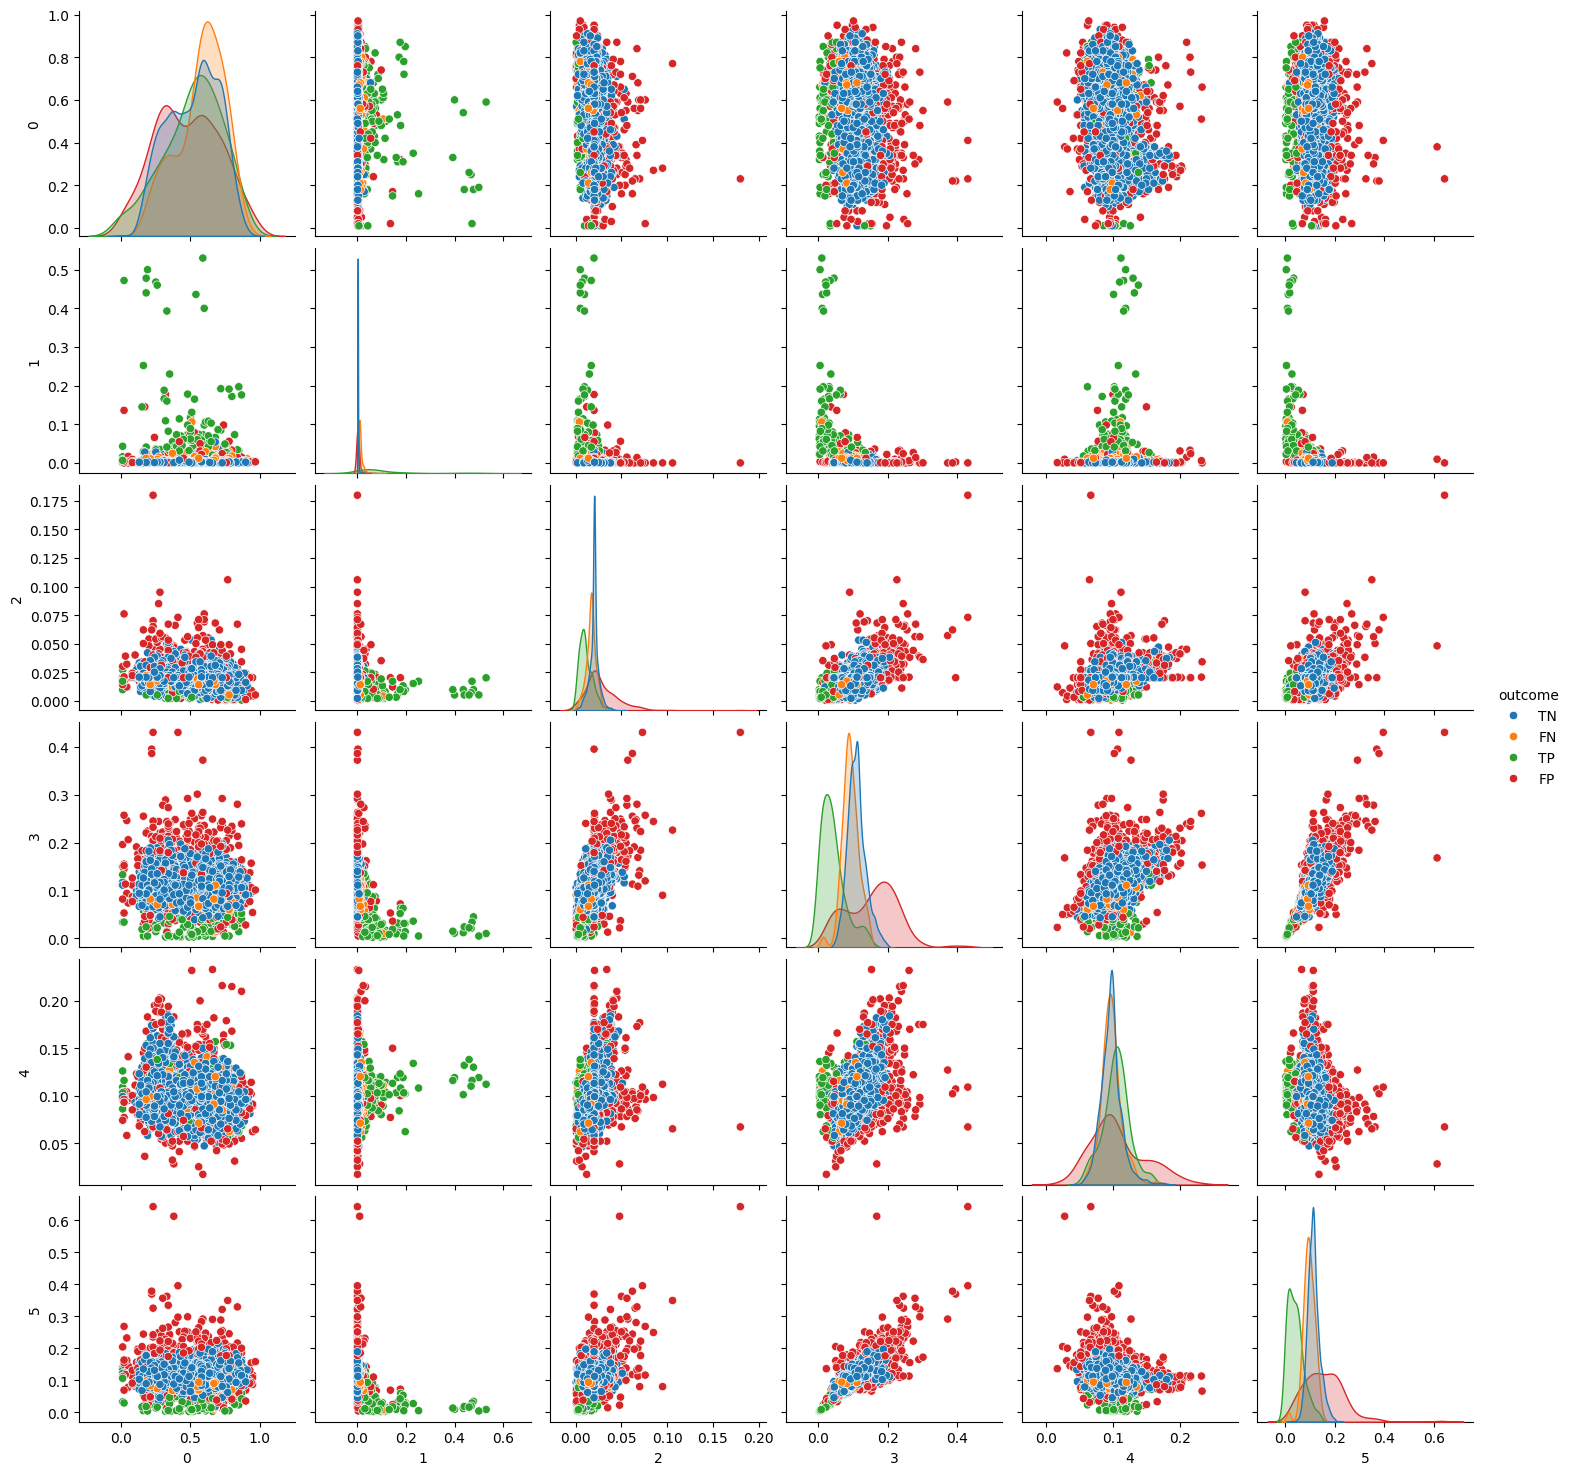

In [ ]:
# Visualize the data distribution (use a subset if too large), coloring true positives, false positives, true negatives, and false negatives

pp = sns.pairplot(df, diag_kind='kde', hue='outcome',  # color by outcome
                  diag_kws=dict(common_norm=False))  # scale kde independently for each outcome
plt.show()

## 6. Explainability with SHAP

In [ ]:
# find index of first true positive
first_tp_index = df[df['outcome'] == 'TP'].index[0]
print(f"Index of the first True Positive: {first_tp_index}")

Index of the first True Positive: 20


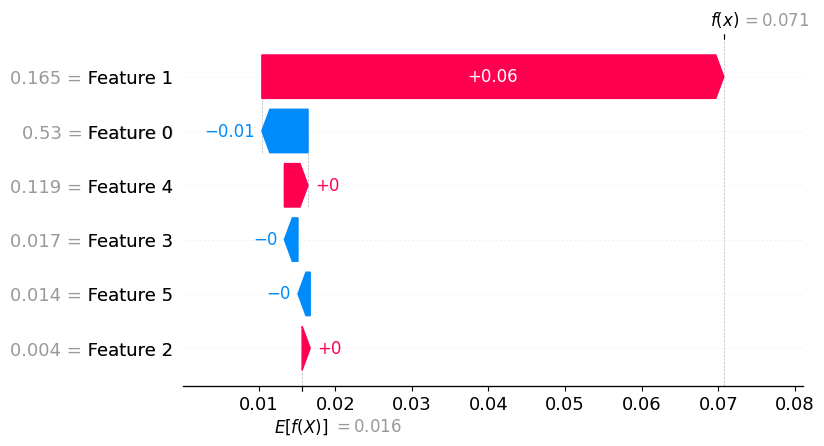

In [ ]:
# Fit SHAP explainer and obtain SHAP values for one observation -- TRUE POSITIVE
explainer = shap.explainers.Exact(clf.decision_function, X_train)
shap_values_exact = explainer(np.array([X_train[first_tp_index,]]))
shap.plots.waterfall(shap_values_exact[0])

# Internal GDL project

## *1. How do different unsupervised anomaly detectors perform across different datasets?*
Limit research to unsupervised anomaly detectors, on the following ADbench datasets:
* annthyroid,
* campaign,
* census,
* donors, and
* skin

Evaluate performance of AD methods using AUC-ROC. Keep in mind different methods have different hyperparameters. Optimizing hyperparameters requires cross-validation.

### Hints

*You may want to subsample datasets to reduce computational load---make sure to stratify on y to preserve class balance of inliers/outliers.*

*While you can run each dataset as a single experiment, it may be more efficient to build a pipeline.*

## *2. How consistent are SHAP explanations for different anomaly detectors?*
Where anomaly detectors agree on predictions, do they give rise to similar SHAP value explanations? How about when they disagree?

[link text] (https://)## *3. How does missing data impact anomaly detection?*
Are different anomaly detection algorithms better suited for datasets where there are more missing values?